### Name: Partha Mehta
### Amsterdam Airbnb Exploratory Analysis and Predictive Model

In [102]:
from google.colab import drive
drive.mount('/content/drive/')

!pwd

import os
os.chdir('/content/drive/MyDrive/airbnb-data-analysis')

!pwd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/airbnb-data-analysis
/content/drive/MyDrive/airbnb-data-analysis


### Required Libraries 

In [103]:
# Preprocessing and Visualisation 
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn import preprocessing

# Predictive Modelling
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split # train-test data split
from sklearn.linear_model import LinearRegression # linear regression

#Accuracy Estimators
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

### About Dataset
<b>Source</b>: http://insideairbnb.com/get-the-data.html
<br><b>Data</b>: San Francisco (Detailed Listings data for San Francisco)
<br> <b>Why this Dataset</b>: Because it was the most recent dataset available

In [104]:
# Data loading
airbnb  = pd.read_csv("detailed_listings.csv")

In [105]:
# Total number of columns and observations in dataset
airbnb.shape

(6789, 75)

There are 6789 observations and 75 columns in the data set (San Francisco and Neighbourhood)

### Data Cleaning

1. Out of all the 75 columns, not all columns are important and required. Dropping unwanted columns like listing_url, scrape_id, last_scraped, thumbnail_url, medium_url, picture_url, xl_picture_url, etc

In [106]:
airbnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [107]:
airbnb = airbnb.drop(["listing_url","scrape_id",'last_scraped','picture_url',
                    'host_url','host_thumbnail_url','host_picture_url','host_has_profile_pic','calendar_last_scraped',
                    'calendar_updated','neighbourhood_group_cleansed','license','host_about'], axis=1)

### Missing Values

The data set have many null values. To preserve all the information, we imputed or dropped the rows and columns containing null values while conducting exploratory analysis that made use of these features.

In [108]:
airbnb.isnull().sum()

id                                                 0
source                                             0
name                                               0
description                                       50
neighborhood_overview                           2048
                                                ... 
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               1227
Length: 62, dtype: int64

1. Out of all the columns with missing values, beds and bedroom are the most important. If ‘beds’ has a missing value, and ‘bedrooms’ has a valid value, ‘beds’ can be set with the value of ‘bedrooms’.If ‘bedrooms’ has a missing value, we will assign it 1 as there will be one room atleast. If both ‘bedrooms’ and ‘beds’ are missing, both fields are set to 1, which is the average number of beds and bedrooms.
2. Number of reviews per month feature has some missing data. For this feature, missing data will be replaced with mean. Since the data is more symmetric, mean replacement would be better.
3. Assuming that there will be atleast one bathroom in each rental property, we replace missingvalues in bathroom with 1. 

In [109]:
airbnb.loc[(airbnb["beds"].isnull()== True) & (airbnb["bedrooms"].isnull()== False), ['beds','bedrooms']] = airbnb["bedrooms"]
airbnb.loc[(airbnb["beds"].isnull()== True) & (airbnb["bedrooms"].isnull()== True), ['beds','bedrooms']] = 1
airbnb.loc[(airbnb["bedrooms"].isnull()== True), ['bedrooms']] = 1
airbnb.loc[(airbnb["bathrooms"].isnull()== True), ['bathrooms']] = 1
airbnb['reviews_per_month'].fillna(airbnb['reviews_per_month'].mean(), inplace=True)

### Quick Glance on the Data set

In [110]:
airbnb.shape

(6789, 62)

In [111]:
len(airbnb.id.unique())

6789

1. There are 6789 unique listing in SF in total with 3603 unique host. The first rental in SF was up in July, 2008 in San Francisco, California.
2. Over 330,349 million reviews have been written by guests since then.
3. The price for a listing ranges from 10.00 USD per night to 25,000 USD per night. None of the rental properties have price per night greater than 25000 USD.
4. On a average, cost of a rental for a night is approximately 268.83 USD

In [112]:
len(airbnb.host_id.unique())

3603

In [113]:
airbnb[['host_since','host_location']].sort_values(by = 'host_since').head(1)

,host_since,host_location
1,2008-07-31,"San Francisco, CA"


In [114]:
airbnb.number_of_reviews.sum()

330349

In [115]:
def clean_currency(x):
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

airbnb = airbnb[airbnb.price > '$0.00']
airbnb['price'] = airbnb['price'].apply(clean_currency).astype('float')

In [116]:
print("$",airbnb['price'].max())
print("$",airbnb['price'].min())

$ 25000.0
$ 10.0


In [117]:
print(len(airbnb[airbnb["price"]>25000.0]))

0


In [118]:
average_price_per_night = round(airbnb["price"].mean(),2)
print("$",average_price_per_night)

$ 268.83


### Exploring the Data set:

1. Find the top 10 host in Amsterdam with maximum rental properties with Airbnb

In [119]:
top_host=airbnb.host_id.value_counts().head(10)
top_host

4430421      153
107434423    141
70722023      68
173206762     61
267895362     55
17042045      48
117141107     43
52178915      43
64646820      38
253575857     36
Name: host_id, dtype: int64

In [120]:
top_host_df=pd.DataFrame(top_host)
top_host_df.reset_index(inplace=True)
top_host_df.rename(columns={'index':'Host_ID', 'host_id':'P_Count'}, inplace=True)
top_host_df

,Host_ID,P_Count
0,4430421,153
1,107434423,141
2,70722023,68
3,173206762,61
4,267895362,55
5,17042045,48
6,117141107,43
7,52178915,43
8,64646820,38
9,253575857,36


[Text(0, 0, '4430421'),
 Text(1, 0, '17042045'),
 Text(2, 0, '52178915'),
 Text(3, 0, '64646820'),
 Text(4, 0, '70722023'),
 Text(5, 0, '107434423'),
 Text(6, 0, '117141107'),
 Text(7, 0, '173206762'),
 Text(8, 0, '253575857'),
 Text(9, 0, '267895362')]

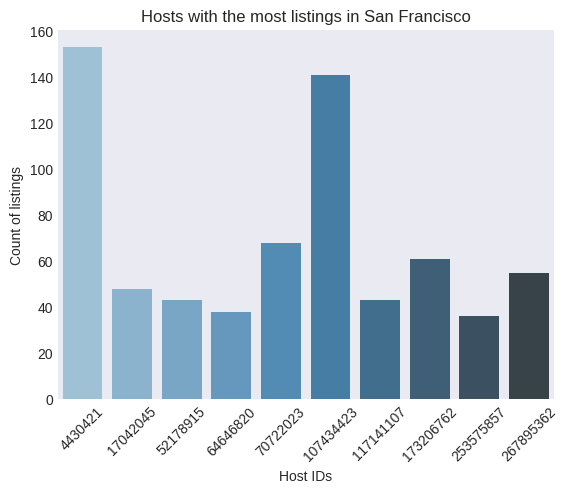

In [121]:
viz_1=sns.barplot(x="Host_ID", y="P_Count", data=top_host_df,
                 palette='Blues_d')
viz_1.set_title('Hosts with the most listings in San Francisco')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Host IDs')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

2. Fining the distribution of room type in SF

In [122]:
room_type_df = airbnb.groupby('room_type').id.count()
room_type_df = room_type_df.reset_index()
room_type_df = room_type_df.rename(columns={'id': 'number_of_listings'})
room_type_df["percentage"] = round((room_type_df["number_of_listings"]/room_type_df.number_of_listings.sum())*100,2)
room_type_df

,room_type,number_of_listings,percentage
0,Entire home/apt,4343,64.00
1,Hotel room,65,0.96
2,Private room,2311,34.06
3,Shared room,67,0.99


<Axes: title={'center': 'Room Type Distribution'}, ylabel='room_type'>

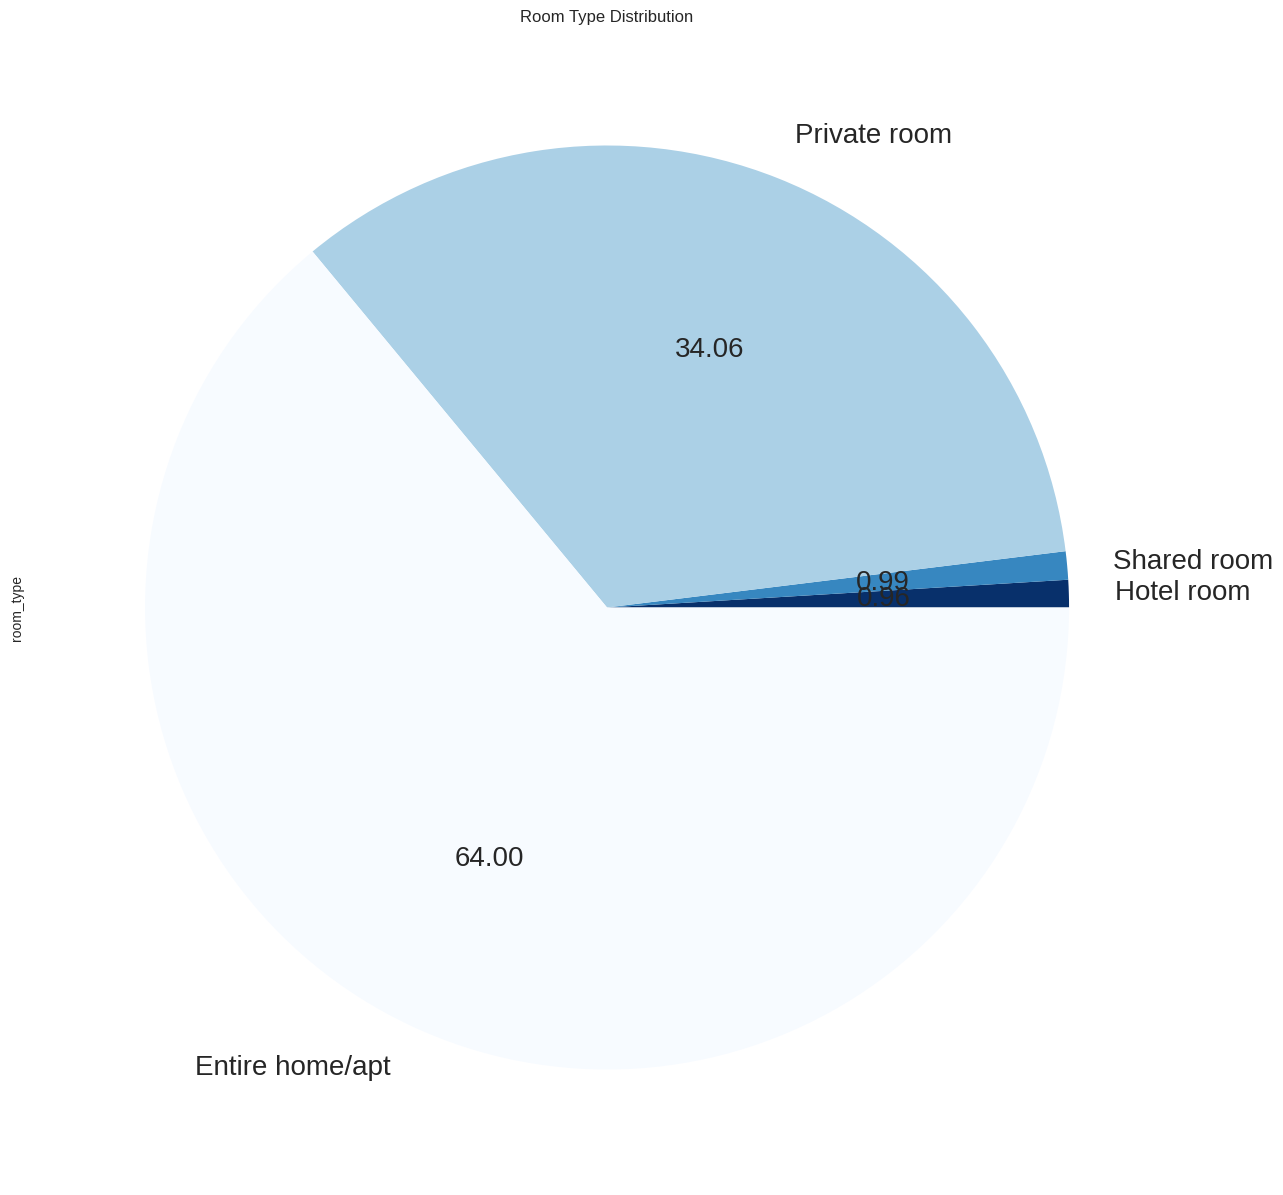

In [123]:
from collections import Counter
# Room Type Rentals Distribution
# number_of_listings = [room_type_df.number_of_listings]
# room_type = room_type_df.room_type
# plt.figure(figsize=(8,8))
# plt.style.use('seaborn-dark')
# plt.pie(x=number_of_listings,labels=room_type,autopct='%1.1f%%',startangle=15, explode=(0, 0.1, 0), colors = ['lightblue','lightsteelblue','silver'])
# plt.title('Room Type Rentals Distribution', fontsize=20)
# plt.show()

room = airbnb.room_type
r = Counter(room)

room_df = pd.DataFrame.from_dict(r, orient='index').sort_values(by=0)
room_df.columns = ['room_type']
room_df.plot.pie(y = 'room_type', 
                 colormap = 'Blues_r', 
                 figsize=(15,15), 
                 fontsize = 20, autopct = '%.2f',
                 legend = False,
                 title = 'Room Type Distribution')

<b>Conclusion</b>: Most of the properties available for rental in SF are Entire home or Apartment

3. Fining the distribution of property type in Amsterdam

In [124]:
property_type_df = airbnb.groupby('property_type').id.count()
property_type_df = property_type_df.reset_index()
property_type_df = property_type_df.rename(columns={'id': 'number_of_listings'})
property_type_df = property_type_df.sort_values(by= 'number_of_listings', ascending = True).tail(10)
property_type_df["percentage"] = round((property_type_df["number_of_listings"]/room_type_df.number_of_listings.sum())*100,2)
property_type_df

,property_type,number_of_listings,percentage
15,Entire serviced apartment,165,2.43
24,Private room in condo,190,2.80
42,Room in hotel,231,3.40
40,Room in boutique hotel,361,5.32
31,Private room in rental unit,460,6.78
7,Entire guest suite,498,7.34
9,Entire home,812,11.97
5,Entire condo,821,12.10
28,Private room in home,847,12.48
13,Entire rental unit,1795,26.45


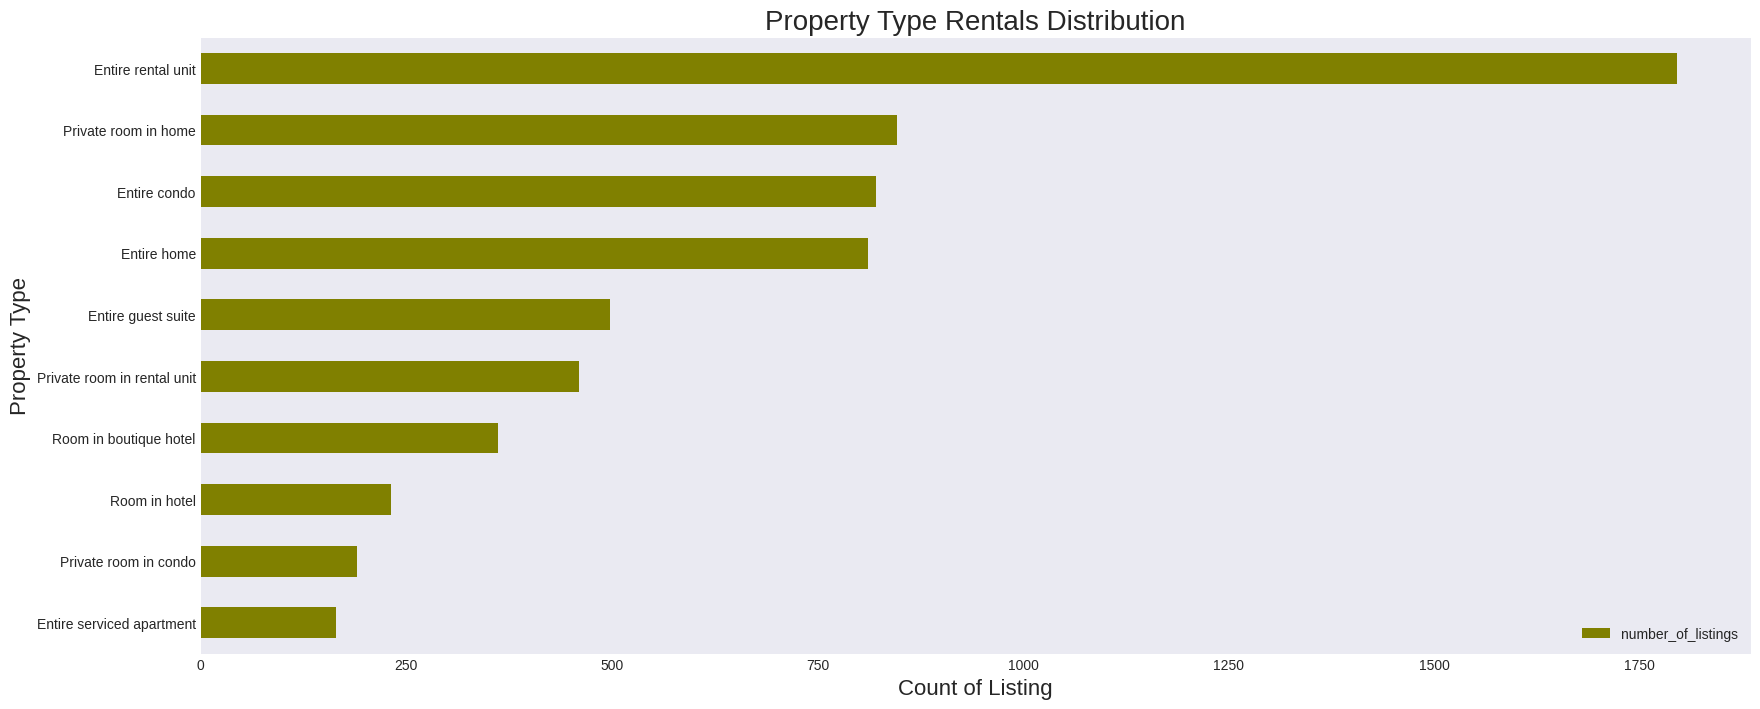

In [125]:
# Property Type Rentals Distribution
property_type_df.plot.barh(x='property_type', y='number_of_listings',figsize=(20,8), color = "olive" )
plt.style.use('seaborn-dark')
plt.title('Property Type Rentals Distribution', fontsize=20)
plt.ylabel('Property Type', fontsize=16)
plt.xlabel('Count of Listing', fontsize=16)
plt.grid(False)
plt.show()

4. HeatMap for price variations with Room Type and Top 10 Property types

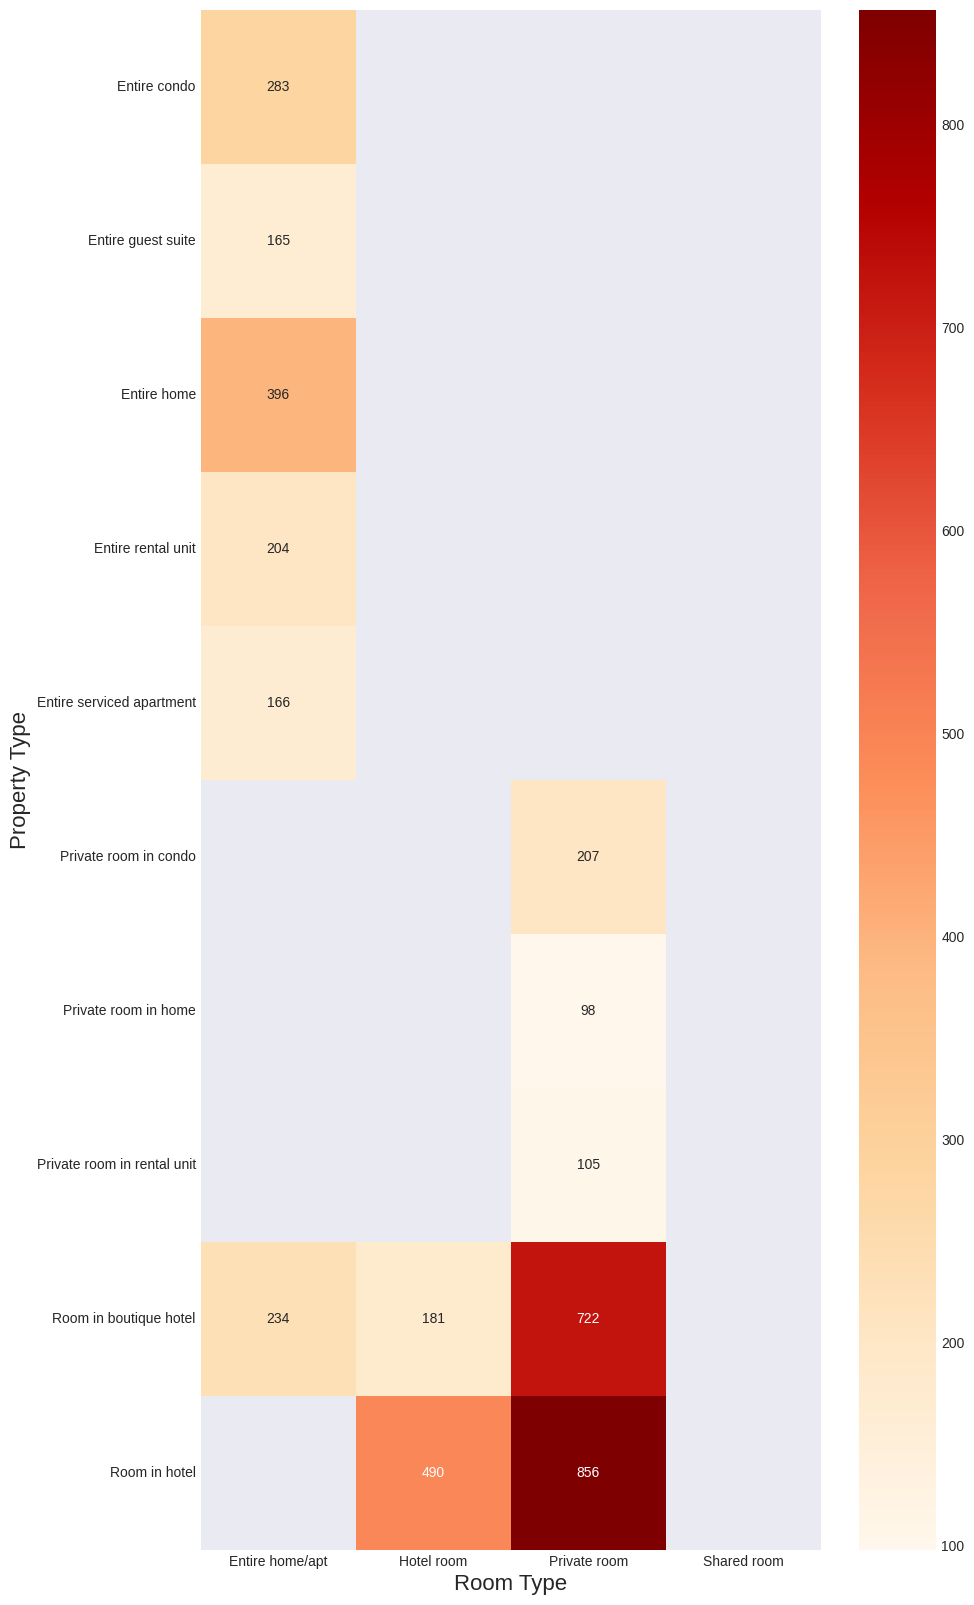

In [126]:
heatmap_df = airbnb.groupby(['property_type', 'room_type']).price.mean().unstack()
heatmap_df = heatmap_df[heatmap_df.index.isin(property_type_df.property_type)]

plt.figure(figsize=(10, 20))
plt.style.use('seaborn-dark')
sns.heatmap(heatmap_df, annot=True, fmt='.0f', cmap ='OrRd')
plt.ylabel('Property Type', fontsize=16)
plt.xlabel('Room Type', fontsize=16)
plt.yticks(rotation=0)
plt.show()

5. HeatMap for price variations with Bedroom Types and Neighbourhood

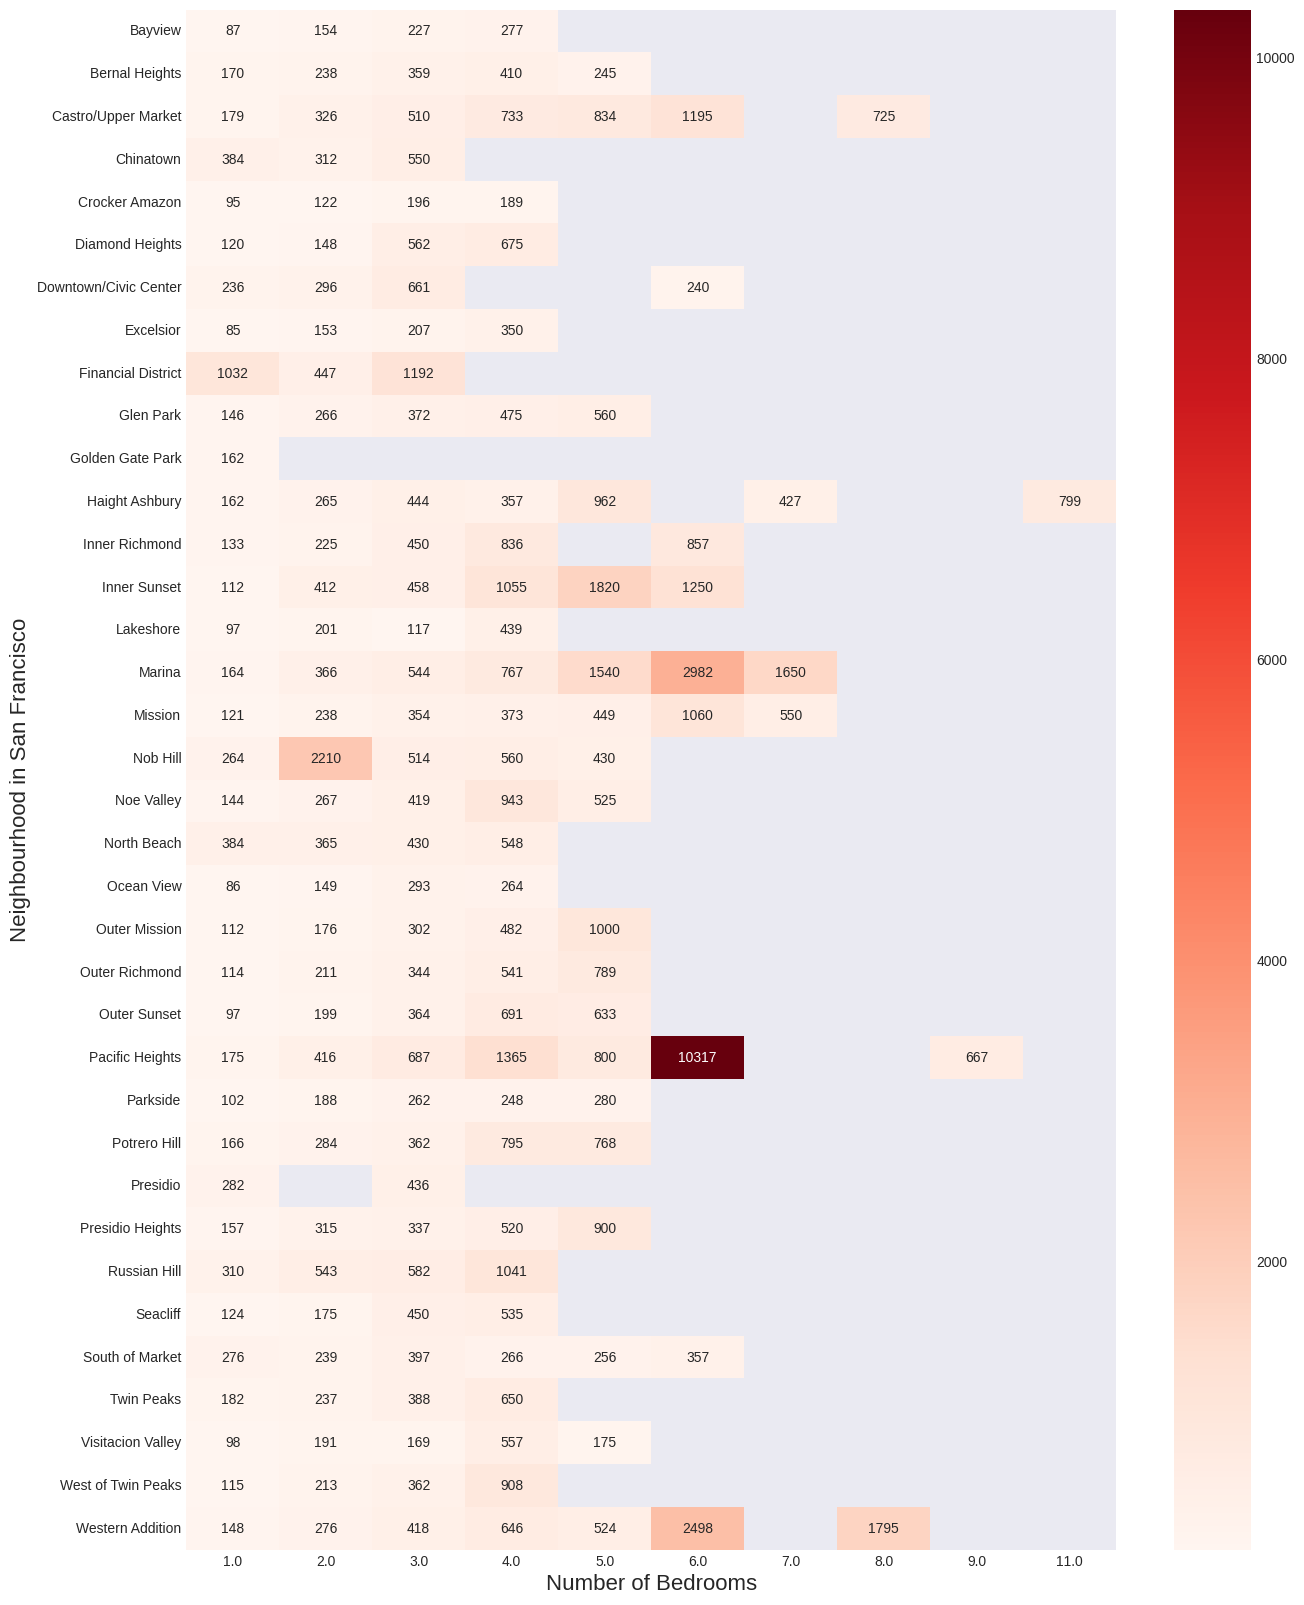

In [127]:
plt.figure(figsize=(15, 20))
plt.style.use('seaborn-dark')
sns.heatmap(airbnb.groupby(['neighbourhood_cleansed', 'bedrooms']).price.mean().unstack(), annot=True, fmt=".0f", cmap = "Reds")
plt.ylabel('Neighbourhood in San Francisco', fontsize=16)
plt.xlabel('Number of Bedrooms', fontsize=16)
plt.show()

6. Distribution of Airbnb rental prices in SF

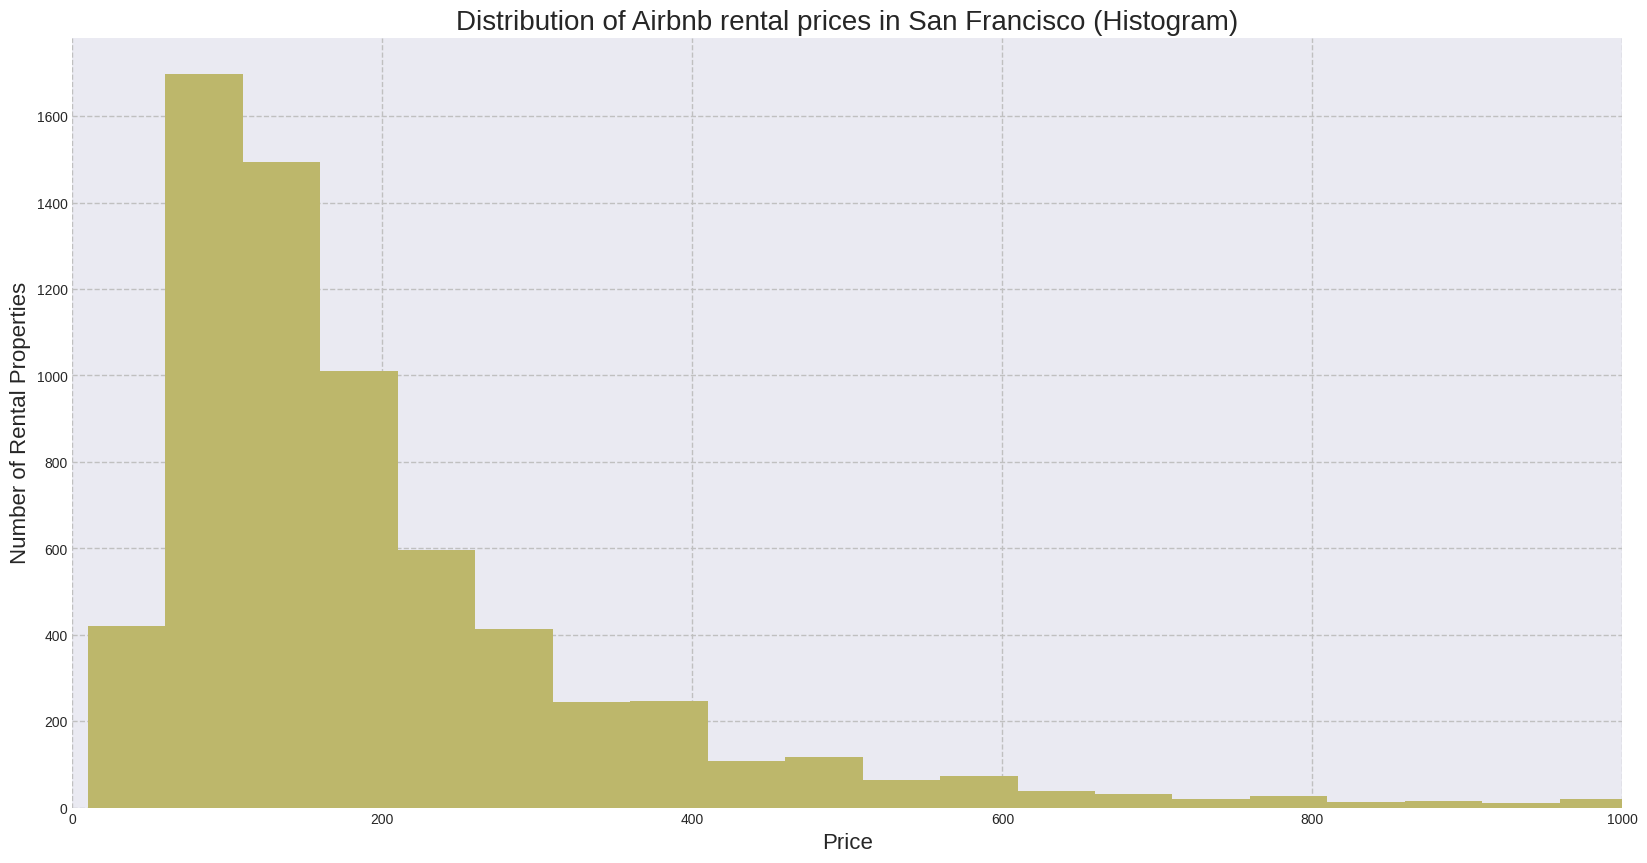

In [128]:
airbnb.hist(column='price', bins=500, grid=True, figsize=(20,10), color = 'darkkhaki')
plt.style.use('seaborn-dark')
plt.title('Distribution of Airbnb rental prices in San Francisco (Histogram)', fontsize=20)
plt.ylabel('Number of Rental Properties', fontsize=16)
plt.xlabel('Price', fontsize=16)
plt.xlim(0,1000)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

The above distribution graph shows that there is a right-skewed distribution on price. This means there is a positive skewness. Log transformation will be used to make this feature less skewed. This will help to make easier interpretation and better statistical analysis

With help of log transformation, now, price feature have normal distribution.

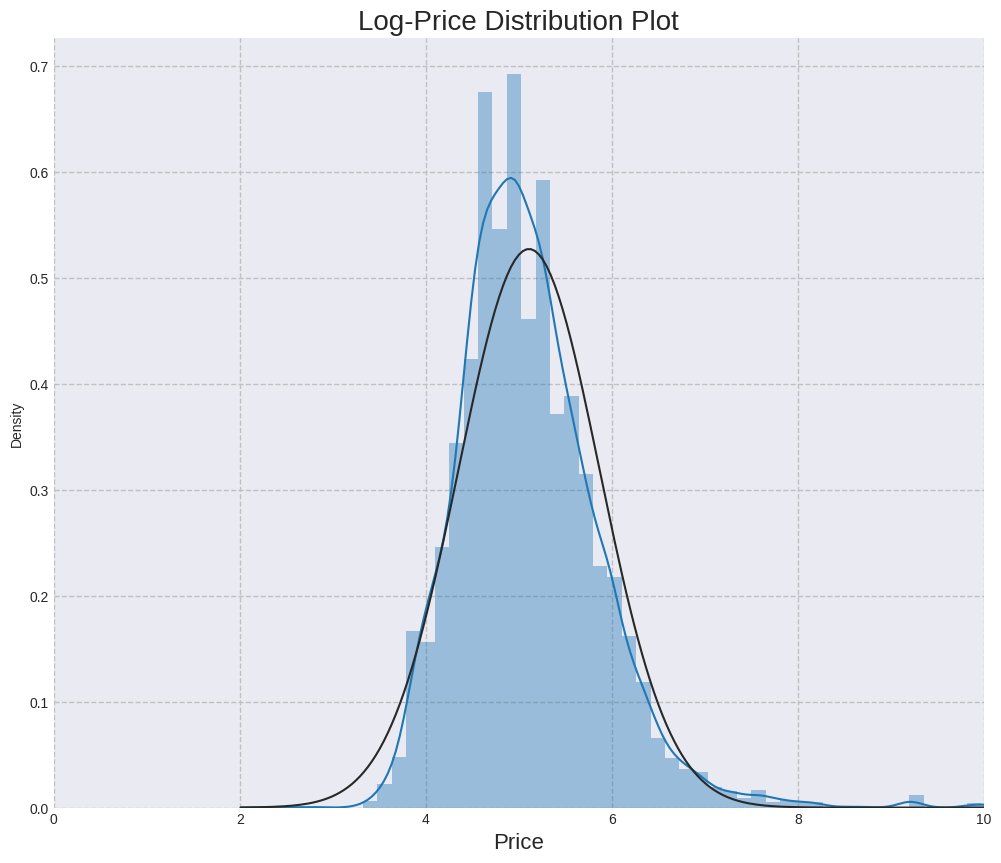

In [129]:
airbnb['price_log'] = np.log(airbnb.price+1)
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,10))
sns.distplot(airbnb['price_log'], fit=norm)
plt.title("Log-Price Distribution Plot", fontsize=20)
plt.xlabel('Price', fontsize=16)
plt.xlim(0,10)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

In below graph, the good fit indicates that normality is a reasonable approximation.

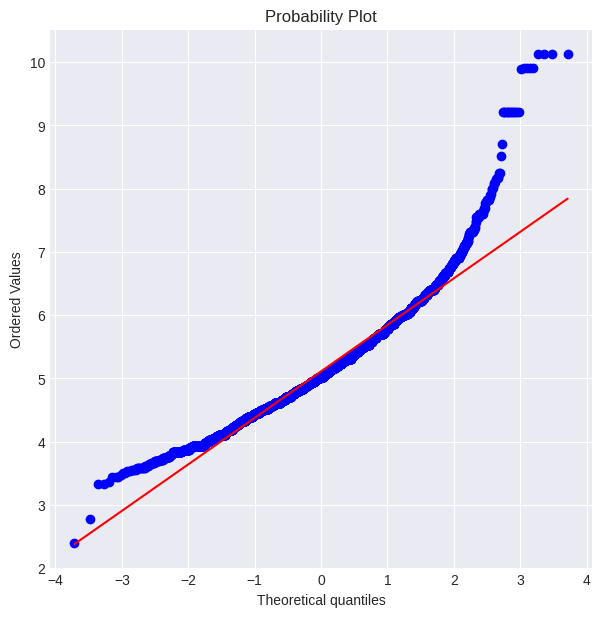

In [130]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(7,7))
stats.probplot(airbnb['price_log'], plot=plt)
plt.grid(True)
plt.show()

Distribution of Airbnb rental prices in SF (Boxplot)

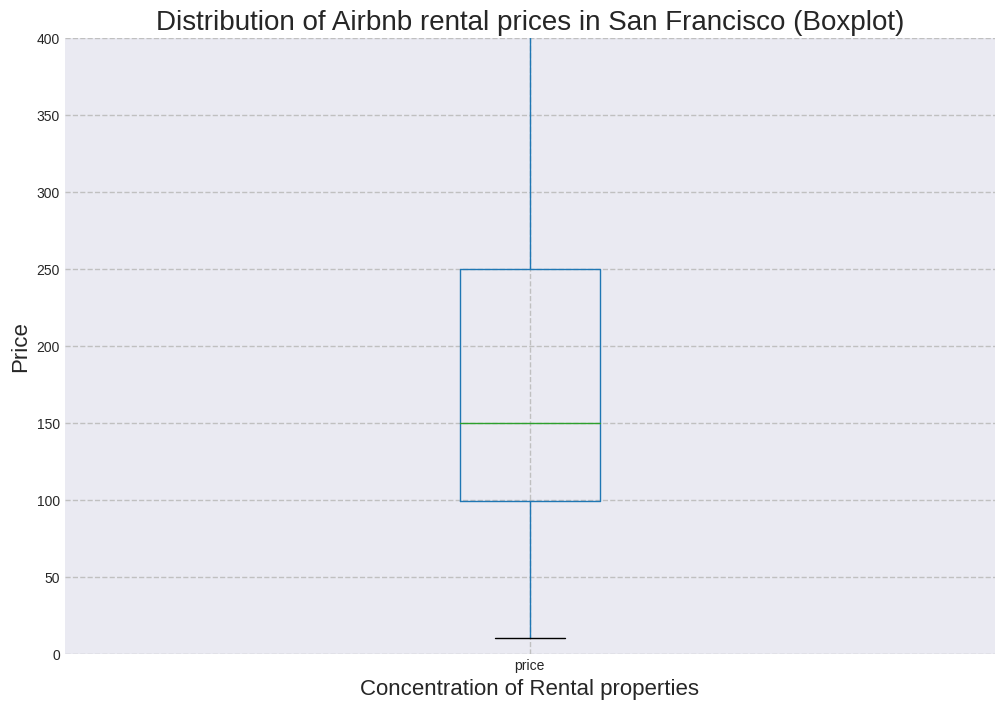

In [131]:
airbnb.boxplot(column='price', grid=True, figsize=(12,8))
plt.style.use('seaborn-dark')
plt.title('Distribution of Airbnb rental prices in San Francisco (Boxplot)', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Concentration of Rental properties', fontsize=16)
plt.ylim(0,400)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

<b> Conclusion </b>: Most properties are available in the range of 100 USD to 250 USD per night with an average of approximately 150 USD

7. Neighbourhood Avergae Price Distribution below 500 USD

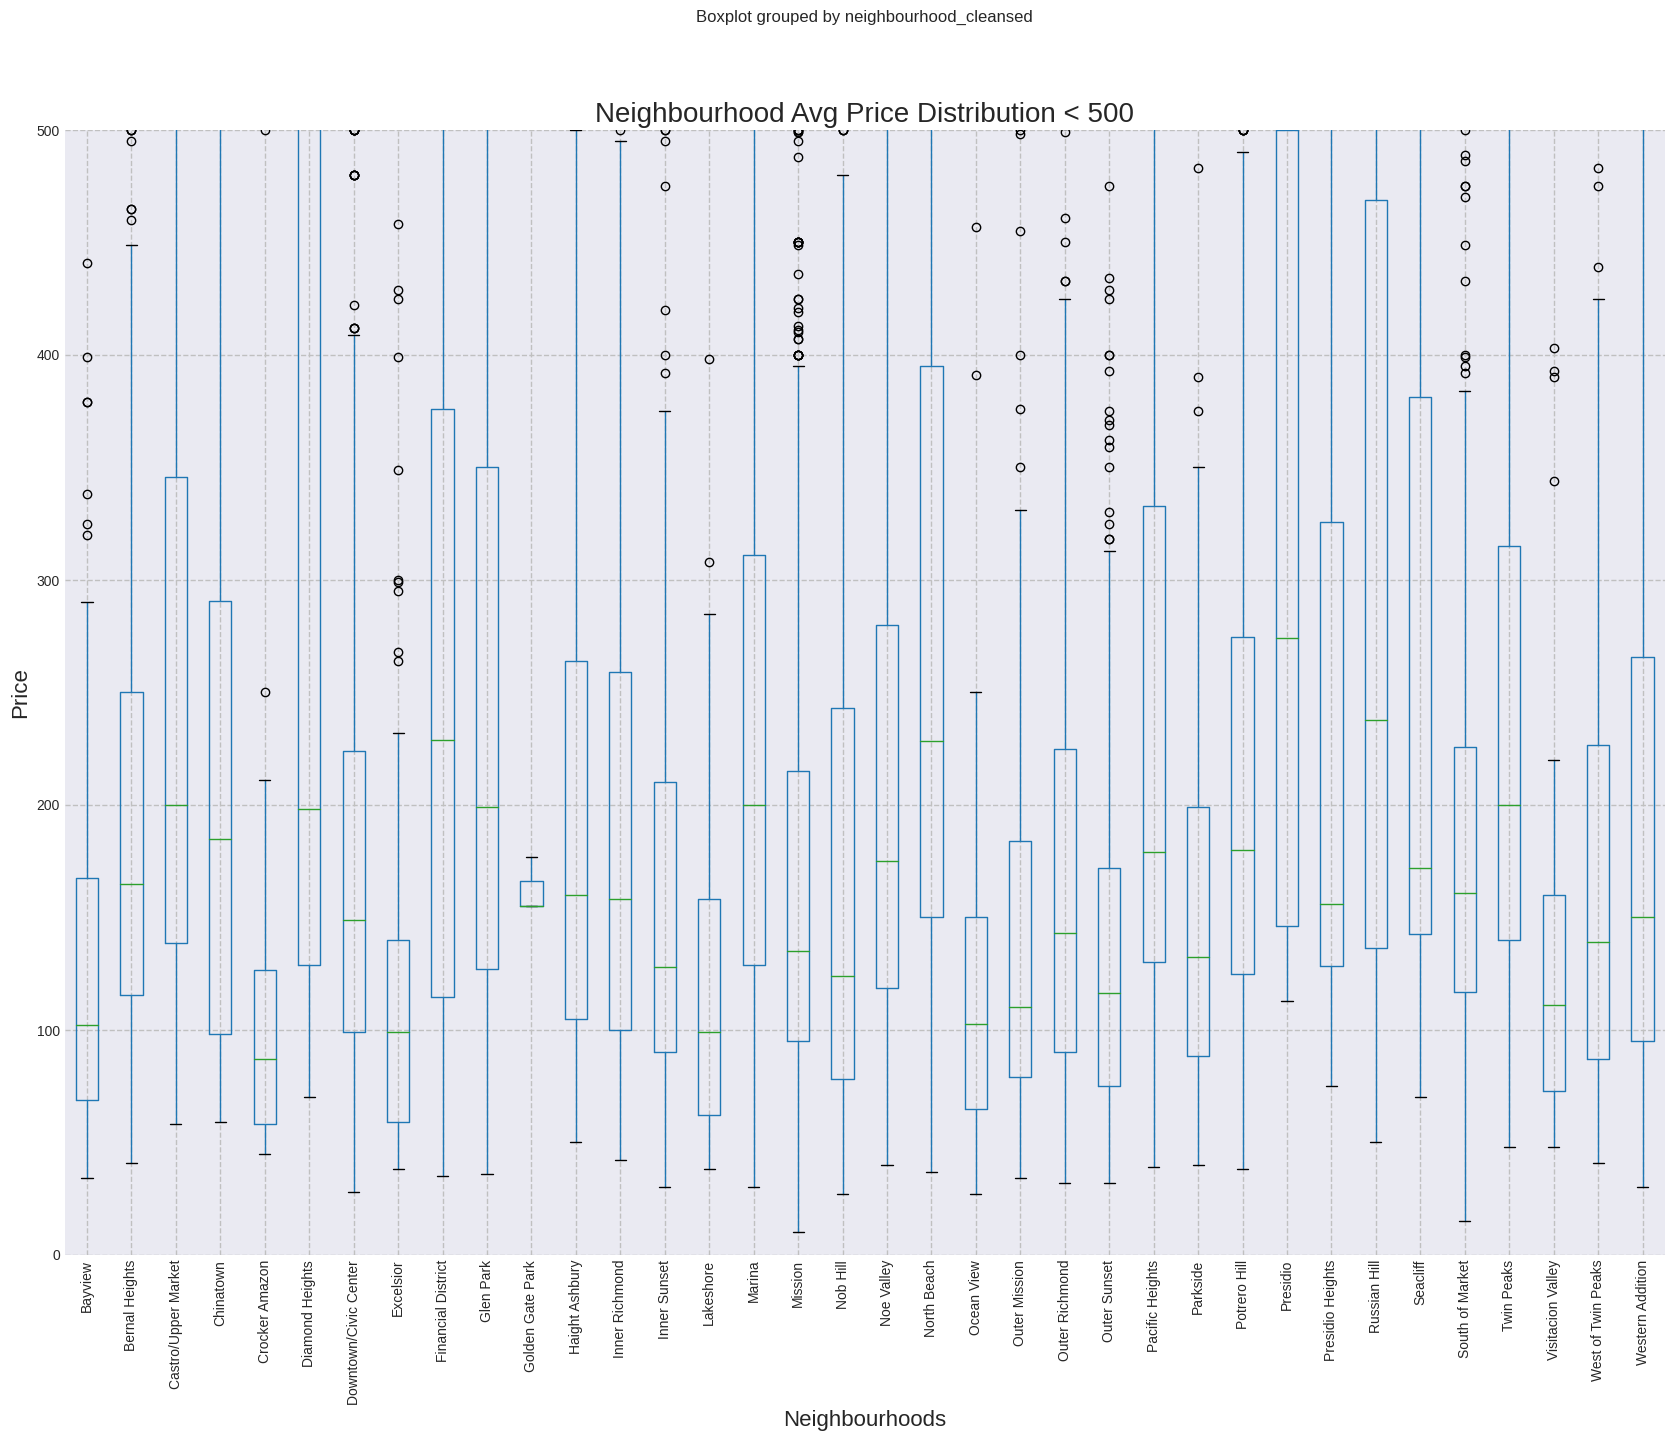

In [132]:
airbnb.boxplot(column='price', by="neighbourhood_cleansed", grid=True, figsize=(20,15))
plt.style.use('seaborn-dark')
plt.title('Neighbourhood Avg Price Distribution < 500', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Neighbourhoods', fontsize=16)
plt.xticks(rotation=90)
plt.ylim(0,500)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

<b>Conclusion</b>: Presidio, Seacliff and Twin Peaks have the most expensive accomodation. Least expensive accomdations are available in Crocker Amazon, Golden Gate Park.

8. Most Common Amenities Available in Rental Properties

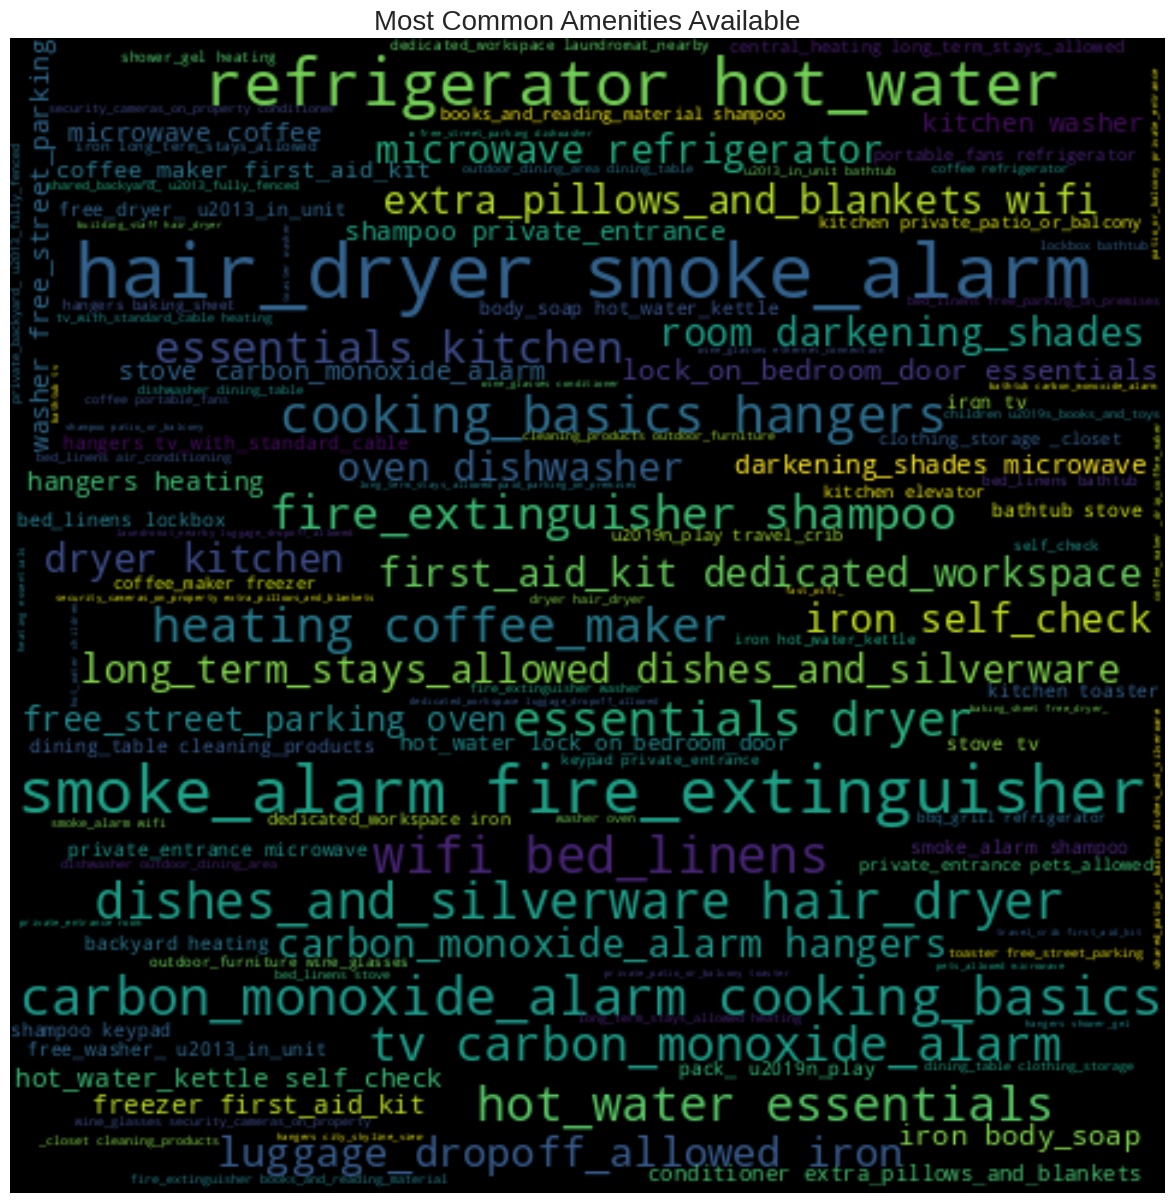

In [133]:
words_list = list()
words_clean = list()
for line in airbnb.amenities:
    words_list.append(line.split(","))

for words in words_list:
    for word in words:
        word = word.strip()
        word = word.replace("{", "")
        word = word.replace("}", "")
        word = word.replace('"', "")
        word = word.lower()
        word = word.replace(" ","_")
        if word.startswith('translation'):
            continue
        words_clean.append(word)
    
how_to_join = " "
words_clean_str = how_to_join.join(words_clean)

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(words_clean_str)
 
# Display the generated image:
plt.figure(figsize=(15, 15))
plt.style.use('seaborn-dark')
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Amenities Available', fontsize=20)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

<b>Conclusion</b>: Most common amenities available are Hair Dryer, Iron, Hangers, Essentials, Shampoo, Wifi and Internet. It is important to note that free parking is not available very commonly. Hence, use public transportation instead of renting a vehicle when in San Francisco to save some money.

### Price Prediction Model (Linear Regression)

1. Creating a DataFrame with only important columns as per the analysis
2. Factorizing Categorical variables for linear regression and finding correlation between variables

In [134]:
airbnb.columns

Index(['id', 'source', 'name', 'description', 'neighborhood_overview',
       'host_id', 'host_name', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', '

In [135]:
price_df = airbnb[["price_log","bedrooms","property_type","accommodates",
                   "availability_30","number_of_reviews","room_type", "reviews_per_month","neighbourhood"]]
price_df["property_type"] = price_df["property_type"].factorize()[0]
price_df["room_type"] = price_df["room_type"].factorize()[0]
price_df["neighbourhood"] = price_df["neighbourhood"].factorize()[0]

Visualising correlation matrix of dependent variables with price

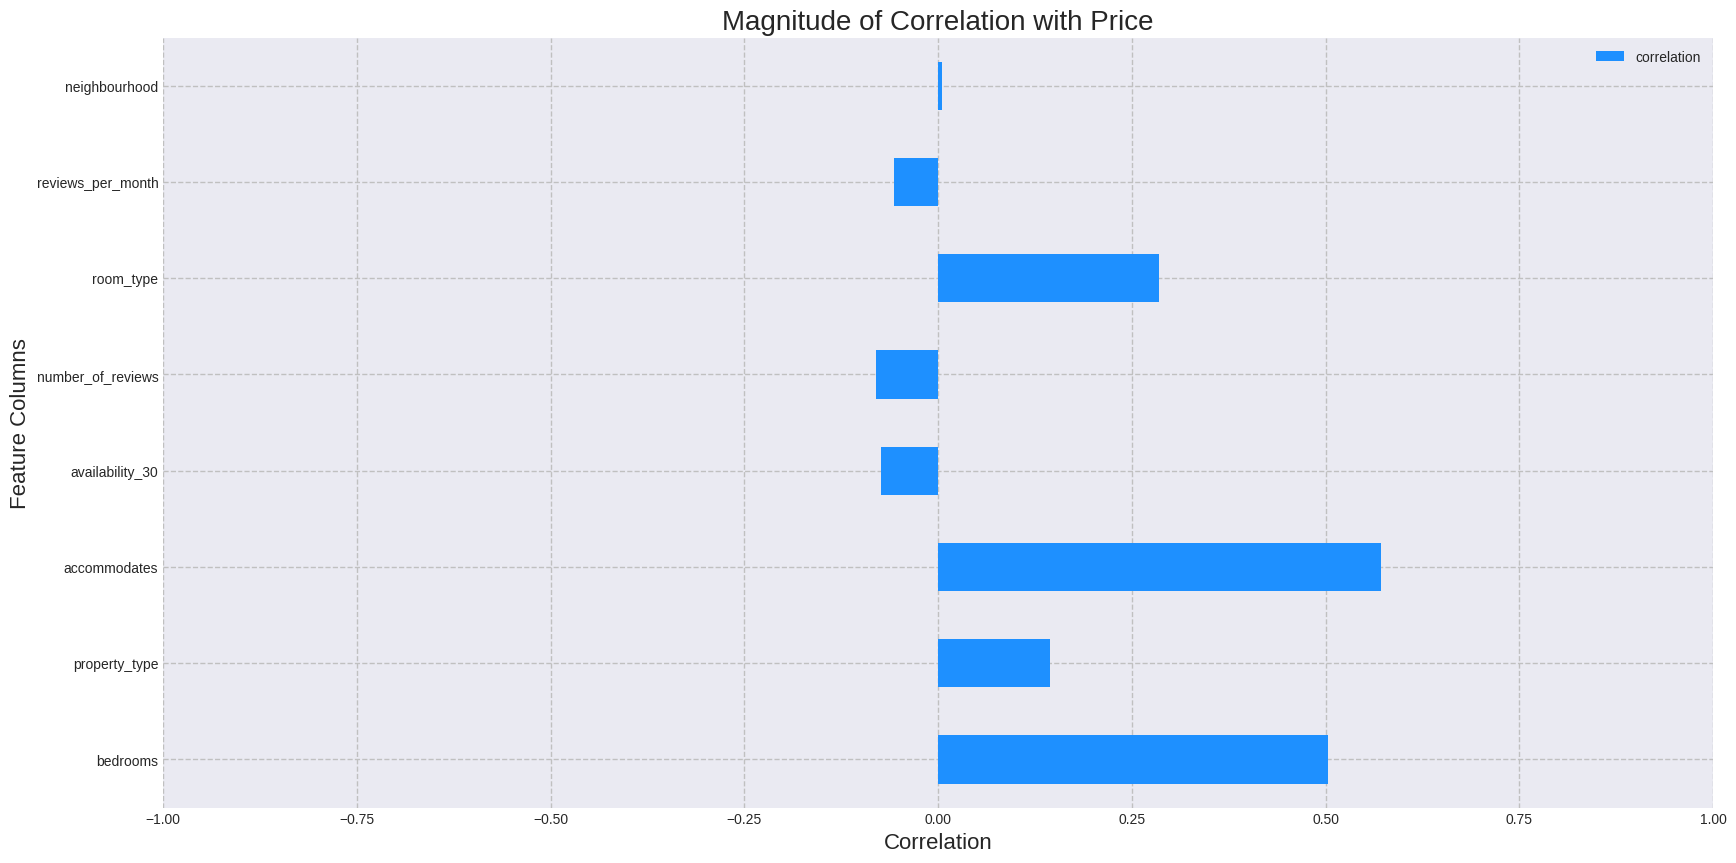

In [136]:
corrMatrix_price = pd.DataFrame(price_df.corrwith(price_df.price_log))
corrMatrix_price = corrMatrix_price.reset_index()
corrMatrix_price = corrMatrix_price.rename(columns={'index': 'feature_columns',0:'correlation'})
corrMatrix_price = corrMatrix_price[corrMatrix_price.feature_columns != "price_log"]
corrMatrix_price.plot.barh(x='feature_columns', y='correlation',figsize=(20,10), color = 'dodgerblue' )
plt.title('Magnitude of Correlation with Price', fontsize=20)
plt.ylabel('Feature Columns', fontsize=16)
plt.xlabel('Correlation', fontsize=16)
plt.xlim(-1.0,1.0)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

<b>Conclusion</b>: Bedrooms and Room Types are highly correlated with price with kind of make sense. More the number of bedrooms, more the price. Also, entire house are more costly than private or shared room.

Creating dependent variable DataFrame and independent variable DataFrame for heatmap and prediction

In [137]:
X = price_df.drop(["price_log"], axis=1)
y = price_df.price_log

The correlation table shows that there is no strong relationship between price and other features. This indicates no feature needed to be taken out of data. 

Text(0.5, 1.0, 'Correlation Matrix')

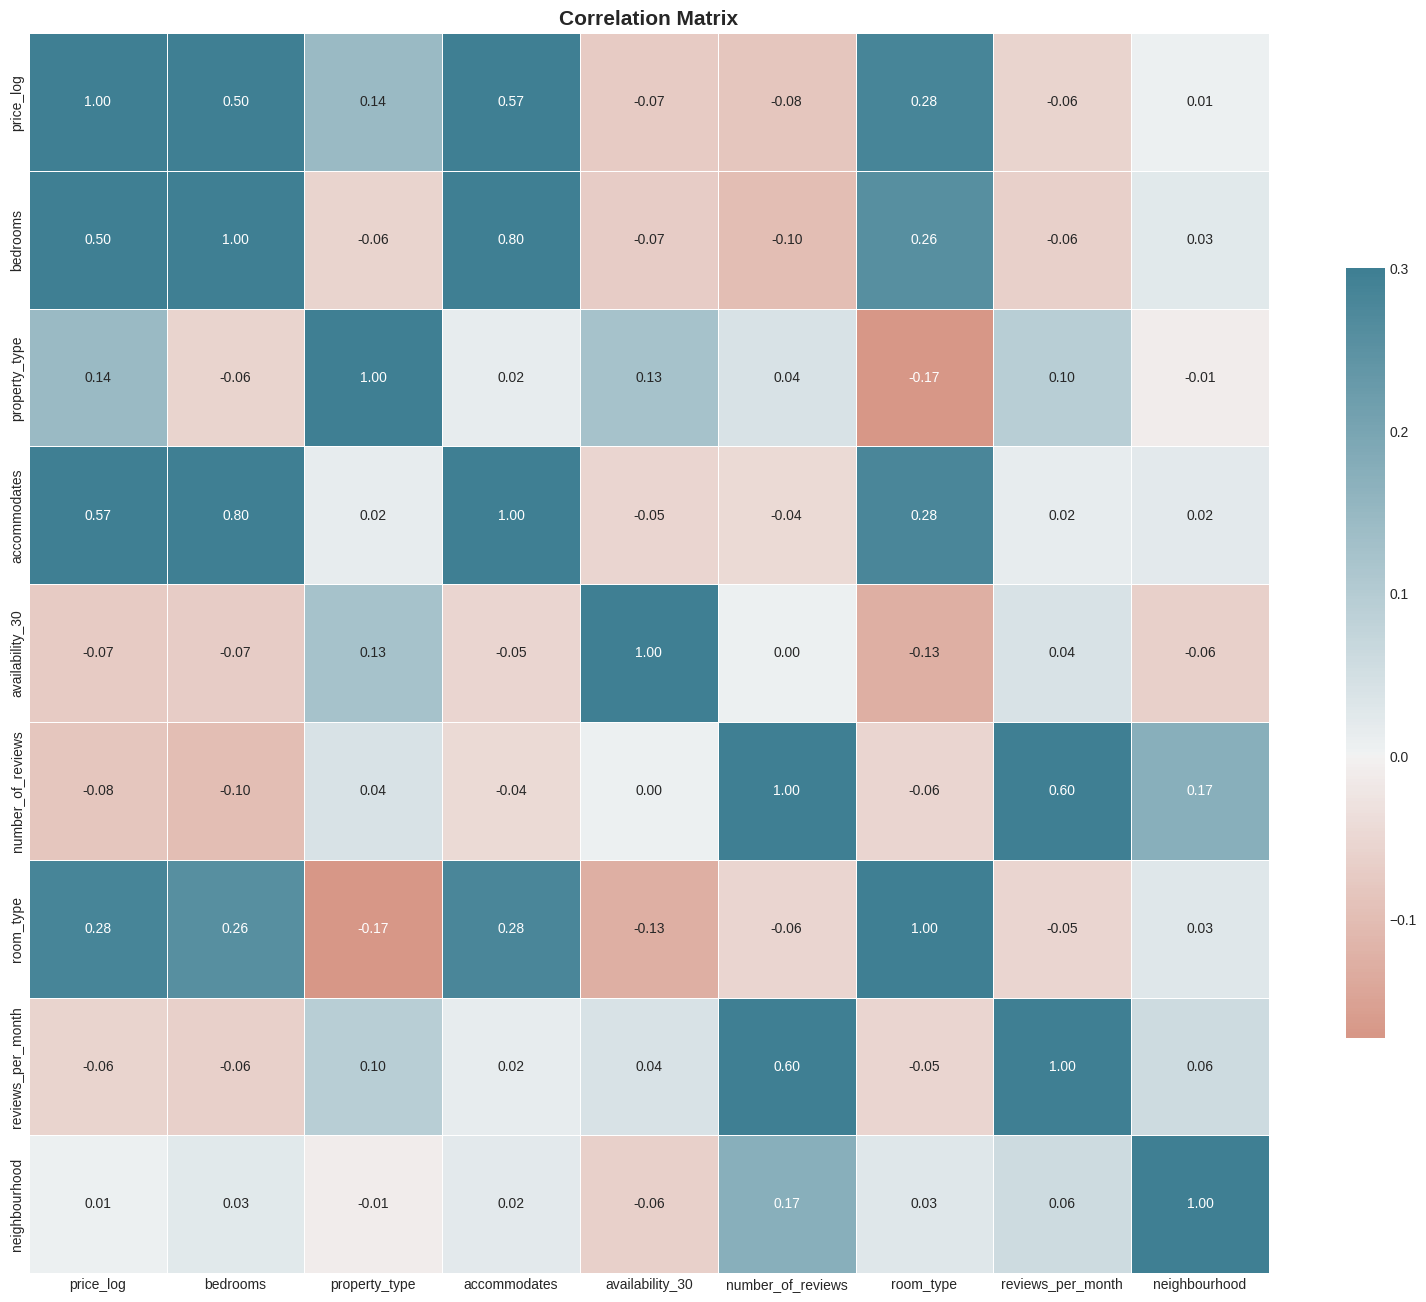

In [138]:
plt.figure(figsize=(20,20))
palette = sns.diverging_palette(20, 220, n=256)
corr=price_df.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Matrix",size=15, weight='bold')  

Multicollinearity will help to measure the relationship between explanatory variables in multiple regression. If there is multicollinearity occurs, these highly related input variables should be eliminated from the model.

In this kernel, multicollinearity will be control with Eigen vector values results.

In [139]:
#Eigen vector of a correlation matrix.
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([2.46052018, 1.63746024, 0.1891305 , 0.47663759, 0.38484677,
       1.23484564, 0.77340011, 0.95737867, 0.88578031])

None one of the eigenvalues of the correlation matrix is close to zero. It means that there is no multicollinearity exists in the data.

Standard Scaler technique will be used to normalize the data set.

In [140]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Test and Train Dataset for prediction

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

Feature Selection and their importance

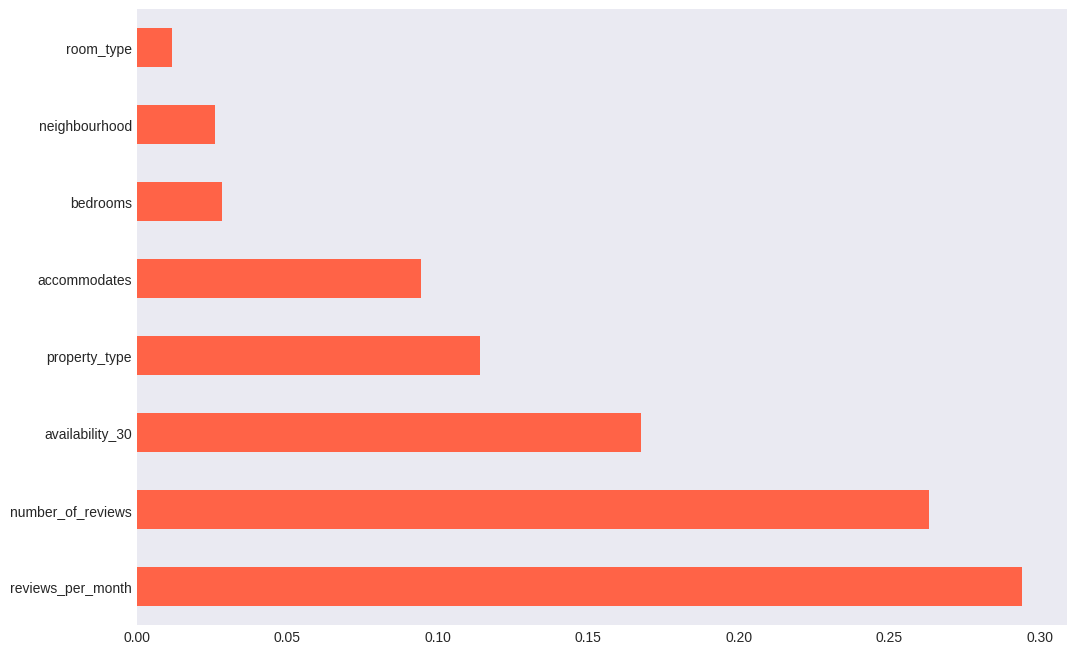

In [142]:
lab_enc = preprocessing.LabelEncoder()

feature_model = ExtraTreesClassifier(n_estimators=50)
feature_model.fit(X_train,lab_enc.fit_transform(y_train))

plt.figure(figsize=(12,8))
feat_importances = pd.Series(feature_model.feature_importances_, index=(price_df.drop(["price_log"], axis=1)).columns)
feat_importances.nlargest(10).plot(kind='barh', color="tomato")
plt.show()

<b>Conclusion</b>: Bedrooms, Neighbourhood and Room Type have lowest importance and can be removed to see if accuracy improves. 

Linear Regression without feature selection

In [144]:
lr = LinearRegression(copy_X= True, fit_intercept = True)
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)
print('--Linear Regression without feature selection--')
print('MAE: %f'% mean_absolute_error(y_test, lr_pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, lr_pred)))   
print('R2: %f' % r2_score(y_test, lr_pred))

--Linear Regression without feature selection--
MAE: 0.418997
RMSE: 0.557429
R2: 0.416983


Dropping lowest important features for prediction

In [145]:
X_f = price_df.drop(["price_log","room_type"], axis=1)
y_f = price_df.price_log

Standard Scaler technique will be used to normalize the data set.

In [146]:
scaler = StandardScaler()
X_f = scaler.fit_transform(X_f)

Test and Train Dataset for prediction

In [147]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25,random_state=42)

Linear Regression without feature selection

In [149]:
lr = LinearRegression(copy_X= True, fit_intercept = True)
lr.fit(X_train_f, y_train_f)
lr_pred_f= lr.predict(X_test_f)
print('--Linear Regression without feature selection--')
print('MAE: %f'% mean_absolute_error(y_test_f, lr_pred_f))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test_f, lr_pred_f)))   
print('R2 %f' % r2_score(y_test_f, lr_pred_f))

--Linear Regression without feature selection--
MAE: 0.428709
RMSE: 0.566811
R2 0.397193


Visualizing Linear Regression Model Predictions

Text(0.5, 1.0, 'Linear Regression Model Predictions')

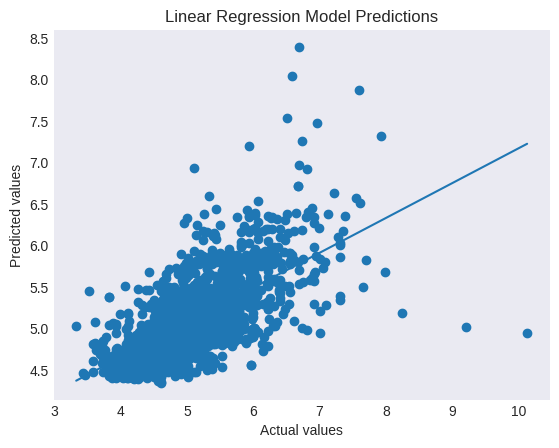

In [153]:
plt.scatter(y_test, lr_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, lr_pred, 1))(np.unique(y_test)))
plt.title("Linear Regression Model Predictions")

In [154]:
airbnb.to_csv('Airbnb Data Exploration and Analysis cleaned.csv',index=False)